<a href="https://colab.research.google.com/github/Bookas1468/data-science-google-colab/blob/main/projects/LukaCookU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here's a link to my dataset.

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data


In [1]:

import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install bambi
import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 9.5 MB/s eta 0:00:00


In [3]:
import kagglehub
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

100%|██████████| 4.63k/4.63k [00:00<00:00, 6.20MB/s]

Extracting files...


This is my dataset as a human-readable table. There area bunch of columns but most of them are just binary yes/no values so I decided to use price area bedrooms stories and parking.

In [4]:
data = pd.read_csv(path+"/Housing.csv")

data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


Initially I was going to use bathrooms instead of parking, but that leade to a circular loop in my causaul diagram that compltely broke the model because it was anticausal.

Here's my causal diagram. Stories goes to price and area, area goes to price bedrooms and parking, parking interacts with price, and bedrooms goes to price. Price is what I'm predicting, the causaul diagram just ended up coming out wierd.

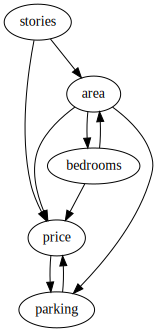

In [5]:
causal = gv.Digraph(name="causal")

causal.node("p",'price')
causal.node("a","area")
causal.node("b","bedrooms")
causal.node('r','parking')
causal.node('s','stories')

causal.edges(['ap','bp','sp','sa','ba','ab','ar','rp','pr'])

causal

Here's a pair plot of my data. It looks kind of wierd in some places since there are a lot of categorical variables but there's still some obvious lean to it.

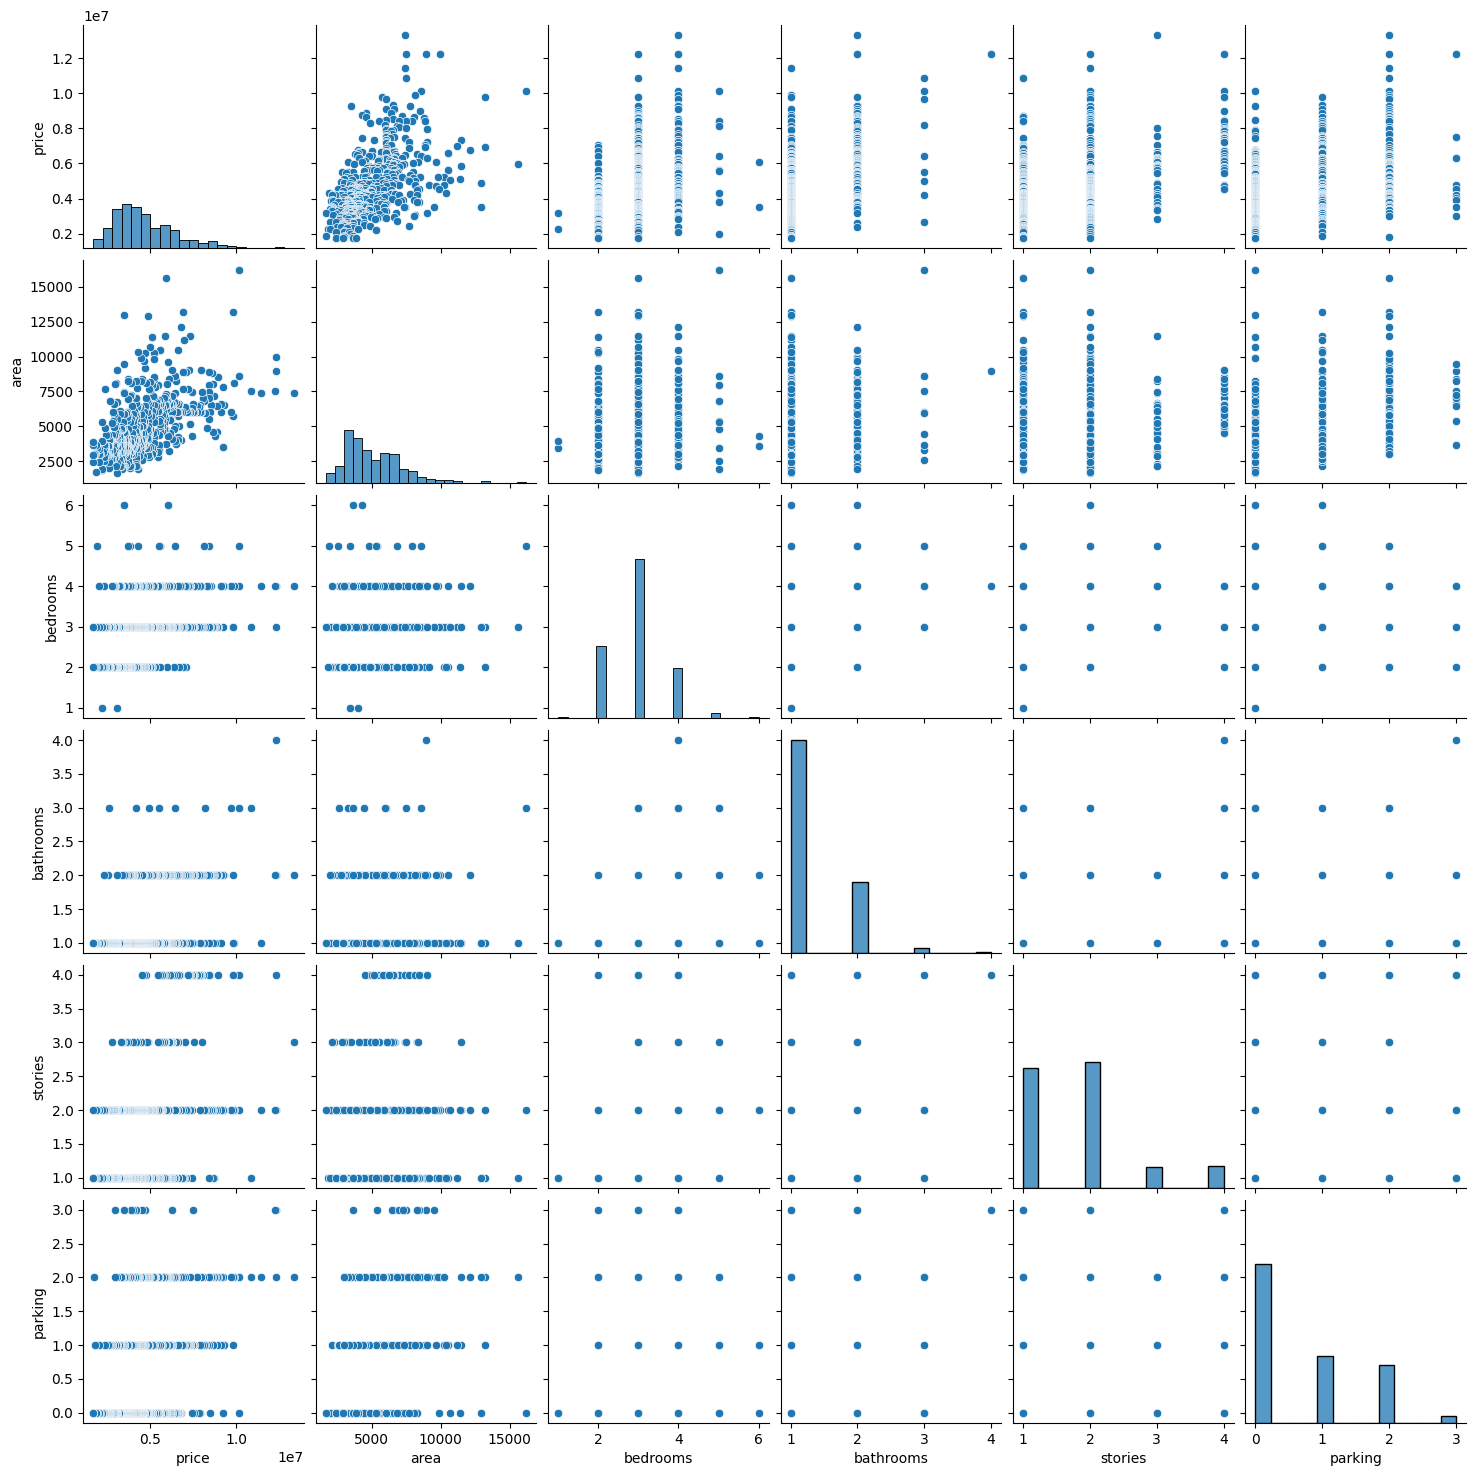

In [6]:
sns.pairplot(data)

Here are all of my models, the names basically explain what they are.

In [ ]:
simple = bmb.Model("price ~ area + bedrooms + parking + stories",data,family="gaussian")

idata_simple = simple.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='price'>

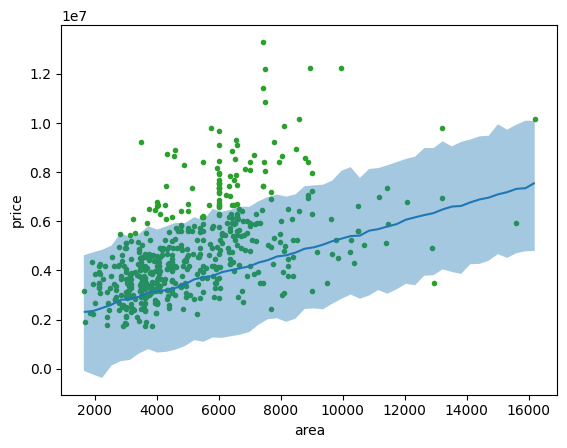

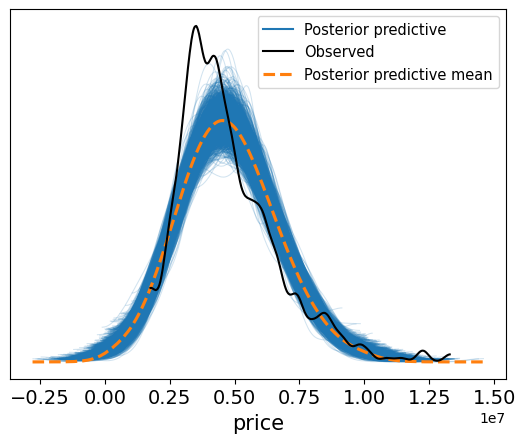

In [8]:
bmb.interpret.plot_predictions(simple, idata_simple, "area",pps=True)
plt.plot(data.area, data.price, "C2.", zorder=-3)

simple.predict(idata_simple, kind="response")
az.plot_ppc(idata_simple)

In [ ]:
hier = bmb.Model("price ~ area + bedrooms + parking + stories + (area|stories) + (price|area) + (parking|area) + (parking|price) + (price|stories)",data,family="gaussian")

idata_hier = hier.fit(idata_kwargs={"log_likelihood":True})

For this model and some other ones the graph is really wierd and the line vs dot graph just doesn't work. I dont know why or how to fix this, so I just didn't include the line vs dot graph.

<Axes: xlabel='price'>

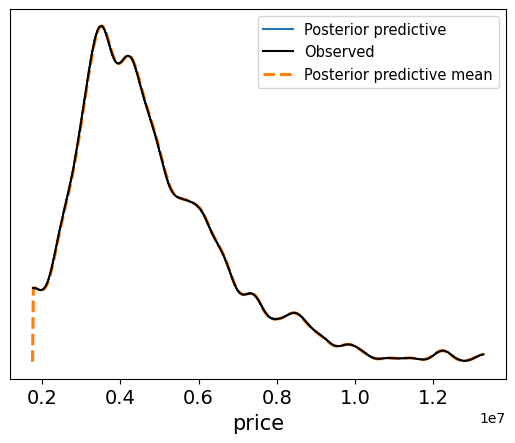

In [17]:
hier.predict(idata_hier, kind="response")
az.plot_ppc(idata_hier)

In [ ]:
inter = bmb.Model("price ~ area + parking + bedrooms + stories + area:bedrooms + parking:price",data,family="gaussian")

idata_inter = inter.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='price'>

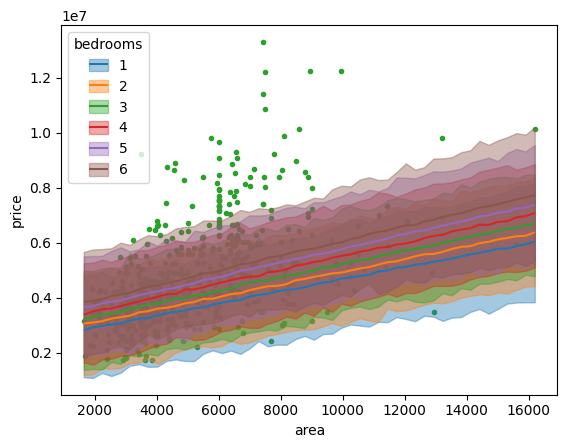

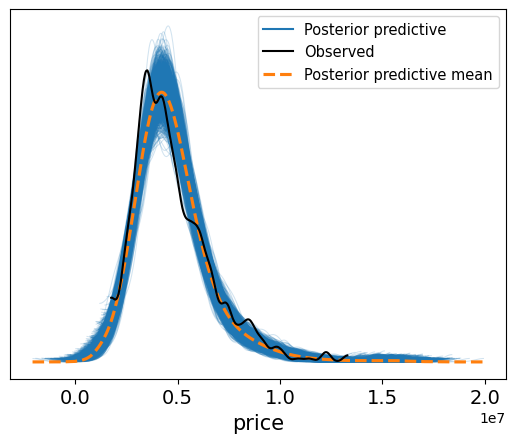

In [12]:
bmb.interpret.plot_predictions(inter, idata_inter, ["area","bedrooms"],pps=True)
plt.plot(data.area, data.price, "C2.", zorder=-3)

inter.predict(idata_inter, kind="response")
az.plot_ppc(idata_inter)

In [ ]:
all = bmb.Model("price ~ area + parking + bedrooms + stories + area:bedrooms + parking:price + (area|stories) + (price|area) + (parking|area) + (parking|price) + (price|stories)",data,family="gaussian")

idata_all = all.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='price'>

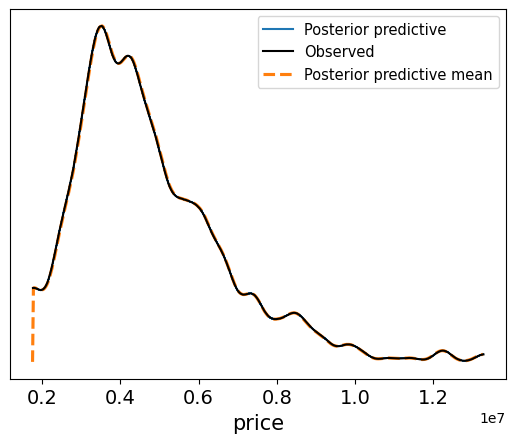

In [14]:
all.predict(idata_all, kind="response")
az.plot_ppc(idata_all)

This is my elpd_loo comparison. As expected, the model with everything performs the best from and elpd_loo standpoint.

In [15]:
comp = az.compare({'simple':idata_simple,'heirarchy':idata_hier,'interactions':idata_inter,'everything':idata_all})
comp

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1057: RuntimeWarning: ove

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
heirarchy,0,316.204883,1496.048598,0.000000,1.000000e+00,10.938766,0.000000,True,log
everything,1,-1223.072089,270.282310,1539.276972,4.415174e-13,62.299858,61.559028,True,log
interactions,2,-8288.108144,13.081506,8604.313027,4.321223e-14,21.443923,23.572363,True,log
simple,3,-8468.598872,8.172301,8784.803756,0.000000e+00,24.041249,24.947624,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

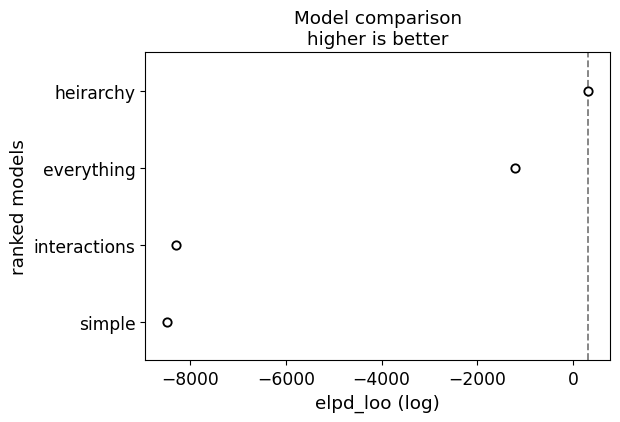

In [18]:
az.plot_compare(comp)

Ultimately I think the model with just heirarchies is the best, but it has a ton of divergences so it's kind of hard to tell.